In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six


In [135]:
from math import sqrt
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline

from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline
pd.pandas.set_option('display.max_columns', None)

from warnings import simplefilter, filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)


In [3]:
#Reading in data
with open('opioid_use_data.csv') as f:
    df = pd.read_csv(f)
f.close()

/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
SEED = 42

In [5]:
df.shape

(160616, 92)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 92 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ClaimID                          160616 non-null  int64  
 1   Accident DateID                  144713 non-null  float64
 2   Claim Setup DateID               160616 non-null  int64  
 3   Report To DateID                 160616 non-null  int64  
 4   Employer Notification DateID     160615 non-null  float64
 5   Benefits State                   160616 non-null  object 
 6   Accident State                   144713 non-null  object 
 7   Industry ID                      160616 non-null  int64  
 8   Claimant Age                     160616 non-null  int64  
 9   Claimant Sex                     160616 non-null  object 
 10  Claimant State                   160300 non-null  object 
 11  Claimant Marital Status          160616 non-null  object 
 12  Nu

In [7]:
df.head(10)

,ClaimID,Accident DateID,Claim Setup DateID,Report To DateID,Employer Notification DateID,Benefits State,Accident State,Industry ID,Claimant Age,Claimant Sex,Claimant State,Claimant Marital Status,Number Dependents,Weekly Wage,Employment Status Flag,RTW Restriction Flag,Max Medical Improvement DateID,Percent Impairment,Post Injury Weekly Wage,NCCI Job Code,Surgery Flag,Disability Status,SIC Group,NCCI BINatureOfLossDescription,Accident Source Code,Accident Type Group,Neurology Payment Flag,Neurosurgery Payment Flag,Dentist Payment Flag,Orthopedic Surgery Payment Flag,Psychiatry Payment Flag,Hand Surgery Payment Flag,Optometrist Payment Flag,Podiatry Payment Flag,HCPCS A Codes,HCPCS B Codes,HCPCS C Codes,HCPCS D Codes,HCPCS E Codes,HCPCS F Codes,HCPCS G Codes,HCPCS H Codes,HCPCS I Codes,HCPCS J Codes,HCPCS K Codes,HCPCS L Codes,HCPCS M Codes,HCPCS N Codes,HCPCS O Codes,HCPCS P Codes,HCPCS Q Codes,HCPCS R Codes,HCPCS S Codes,HCPCS T Codes,HCPCS U Codes,HCPCS V Codes,HCPCS W Codes,HCPCS X Codes,HCPCS Y Codes,HCPCS Z Codes,ICD Group 1,ICD Group 2,ICD Group 3,ICD Group 4,ICD Group 5,ICD Group 6,ICD Group 7,ICD Group 8,ICD Group 9,ICD Group 10,ICD Group 11,ICD Group 12,ICD Group 13,ICD Group 14,ICD Group 15,ICD Group 16,ICD Group 17,ICD Group 18,ICD Group 19,ICD Group 20,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Benzo,NDC Class - Misc (Zolpidem),NDC Class - Muscle Relaxants,NDC Class - Stimulants,Opiods Used
0,7275,33460.0,33467,33462,33460.0,OK,OK,17,41,M,OK,M,0,513.86,F,Y,NaN,0,0.0,5040,0,TTD,Gen. cont.,Strain,NaN,ATCgr7,False,False,False,False,False,False,False,False,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,12,0,0,0,7,1,3,5,1,0,0,0,0,False
1,17596,NaN,34301,34300,34270.0,CO,NaN,17,49,M,CO,M,0,1186.00,F,N,34726.0,10,0.0,5190,0,PPD,Gen. cont.,Inflammation,6314.0,ATCgr6,False,False,False,True,False,False,False,True,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,12,0,0,0,0,0,12,0,4,1,4,12,1,4,9,0,0,0,0,True
2,13834,35043.0,35054,35050,35043.0,MD,MD,17,47,M,VA,U,0,851.69,F,N,35051.0,0,0.0,5183,0,TTD,Gen. cont.,Foreign Body,NaN,NaN,False,False,False,False,False,False,True,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,2,0,0,0,0,False
3,5719,33136.0,33147,33145,33136.0,IL,IL,9,35,F,IL,M,0,300.00,P,N,NaN,0,0.0,8868,0,TTD,Misc. Manuf. Ind.,Strain,7726.0,ATCgr6,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,1,0,2,0,0,0,1,0,False
4,8646,33262.0,33277,33264,33264.0,IL,IL,9,30,F,WI,M,0,600.00,F,,NaN,0,0.0,8868,0,TTD,Misc. Manuf. Ind.,Contusions,NaN,ATCgr1,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,2,6,0,0,0,2,4,0,6,0,0,0,0,0,False
5,19175,33305.0,34223,34222,34197.0,CA,CA,10,41,M,CA,S,0,385.07,F,,35030.0,6,0.0,4558,0,PPD,Misc. Services,Strain,NaN,ATCgr6,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
6,9640,34148.0,34189,34187,34182.0,CA,CA,2,35,M,CA,M,0,1076.00,F,Y,NaN,0,0.0,8810,1,TTD,Business Services,NaN,NaN,ATCgr6,False,False,False,False,False,True,False,False,0,0,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,4,1,3,12,1,2,3,0,0,0,0,False
7,15694,33482.0,33493,33487,33486.0,IL,IL,14,40,M,IL,M,0,1478.83,F,Y,NaN,0,0.0,7229,0,TPD,Trans. Equip.,Sprain,NaN,ATCgr5,False,False,False,False,False,False,False,False,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,8,0,0,1,0,0,0,0,False
8,4923,33496.0,33507,33502,33498.0,CA,CA,18,22,F,CA,S,0,720.00,F,N,NaN,0,0.0,8601,0,TTD,Ins. Agnts. Brkrs. 

## Deleting Initial Features
- Delete features which have all unique observiations, which are highly correlated and/or have 90-95% of missing values

In [8]:
# We can remove ClaimID since each observation has a unique value
for var in df.columns:
    print(var, df[var].nunique(), len(df))

ClaimID 160616 160616
Accident DateID 2508 160616
Claim Setup DateID 2396 160616
Report To DateID 2019 160616
Employer Notification DateID 2538 160616
Benefits State 52 160616
Accident State 61 160616
Industry ID 21 160616
Claimant Age 92 160616
Claimant Sex 4 160616
Claimant State 60 160616
Claimant Marital Status 5 160616
Number Dependents 16 160616
Weekly Wage 75472 160616
Employment Status Flag 14 160616
RTW Restriction Flag 4 160616
Max Medical Improvement DateID 2504 160616
Percent Impairment 95 160616
Post Injury Weekly Wage 1355 160616
NCCI Job Code 2072 160616
Surgery Flag 2 160616
Disability Status 4 160616
SIC Group 51 160616
NCCI BINatureOfLossDescription 15 160616
Accident Source Code 11 160616
Accident Type Group 16 160616
Neurology Payment Flag 2 160616
Neurosurgery Payment Flag 2 160616
Dentist Payment Flag 2 160616
Orthopedic Surgery Payment Flag 2 160616
Psychiatry Payment Flag 2 160616
Hand Surgery Payment Flag 2 160616
Optometrist Payment Flag 2 160616
Podiatry Paym

In [9]:
df.drop('ClaimID', axis=1, inplace=True)

In [10]:
# Highly correlated features can be removed
df_copy = df.copy()
corr_matrix = df_copy.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

upper

,Accident DateID,Claim Setup DateID,Report To DateID,Employer Notification DateID,Industry ID,Claimant Age,Number Dependents,Weekly Wage,Max Medical Improvement DateID,Percent Impairment,Post Injury Weekly Wage,Surgery Flag,Accident Source Code,Neurology Payment Flag,Neurosurgery Payment Flag,Dentist Payment Flag,Orthopedic Surgery Payment Flag,Psychiatry Payment Flag,Hand Surgery Payment Flag,Optometrist Payment Flag,Podiatry Payment Flag,HCPCS A Codes,HCPCS B Codes,HCPCS C Codes,HCPCS D Codes,HCPCS E Codes,HCPCS F Codes,HCPCS G Codes,HCPCS H Codes,HCPCS I Codes,HCPCS J Codes,HCPCS K Codes,HCPCS L Codes,HCPCS M Codes,HCPCS N Codes,HCPCS O Codes,HCPCS P Codes,HCPCS Q Codes,HCPCS R Codes,HCPCS S Codes,HCPCS T Codes,HCPCS U Codes,HCPCS V Codes,HCPCS W Codes,HCPCS X Codes,HCPCS Y Codes,HCPCS Z Codes,ICD Group 1,ICD Group 2,ICD Group 3,ICD Group 4,ICD Group 5,ICD Group 6,ICD Group 7,ICD Group 8,ICD Group 9,ICD Group 10,ICD Group 11,ICD Group 12,ICD Group 13,ICD Group 14,ICD Group 15,ICD Group 16,ICD Group 17,ICD Group 18,ICD Group 19,ICD Group 20,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Benzo,NDC Class - Misc (Zolpidem),NDC Class - Muscle Relaxants,NDC Class - Stimulants,Opiods Used
Accident DateID,NaN,0.992483,0.993462,0.995020,0.004154,0.010695,0.036018,0.010670,0.903402,0.134289,0.049074,0.135031,0.054814,0.038273,0.037529,0.019431,0.091537,0.057880,0.018759,0.004128,0.066799,0.085595,0.004589,0.010104,0.006228,0.108151,0.033867,0.030992,0.005061,0.008981,0.066734,0.016273,0.068934,0.103838,0.049762,0.018378,0.043105,0.036460,0.008612,0.034857,0.029229,0.001773,0.007001,0.094704,0.003217,0.002318,0.049492,0.039893,0.037396,0.028689,0.040333,0.071203,0.171896,0.033241,0.033784,0.066827,0.047526,0.067651,0.054951,0.315585,0.038981,0.008637,0.014260,0.039070,0.135190,0.052350,0.031032,0.186262,0.124726,0.160121,0.190538,0.106322,0.135261,0.149116,0.044144,0.052774,0.070667,0.001963,0.145555
Claim Setup DateID,NaN,NaN,0.999172,0.997141,0.003075,0.004492,0.041018,0.007758,0.911597,0.127034,0.044831,0.136179,0.056502,0.038616,0.038605,0.020792,0.096506,0.061228,0.019982,0.006546,0.069855,0.089091,0.005886,0.012562,0.003996,0.109118,0.033712,0.029270,0.005735,0.006528,0.072640,0.016624,0.076742,0.091498,0.051455,0.018336,0.043757,0.039663,0.007898,0.037829,0.016988,0.001232,0.007632,0.099099,0.000462,0.001960,0.047623,0.041074,0.040108,0.031985,0.042532,0.076875,0.177359,0.035814,0.035641,0.072057,0.051272,0.072338,0.060656,0.332064,0.041857,0.010600,0.014043,0.042083,0.144563,0.061913,0.032623,0.199341,0.130649,0.176621,0.193041,0.107506,0.140116,0.154839,0.043585,0.052496,0.073857,0.001477,0.147656
Report To DateID,NaN,NaN,NaN,0.997972,0.003196,0.005053,0.040825,0.008037,0.911207,0.127554,0.044856,0.135707,0.056373,0.038550,0.038562,0.020794,0.096098,0.061112,0.019748,0.006329,0.069654,0.088358,0.005850,0.012360,0.003884,0.108746,0.033553,0.029431,0.005795,0.006528,0.072018,0.016496,0.075972,0.091741,0.051531,0.018322,0.043714,0.039290,0.007914,0.037552,0.017190,0.001236,0.007636,0.099280,0.000589,0.001946,0.047787,0.040998,0.040109,0.031834,0.042384,0.076908,0.177104,0.035678,0.035569,0.071881,0.051053,0.072168,0.060427,0.331684,0.041741,0.010529,0.014000,0.041984,0.144216,0.061503,0.032521,0.198877,0.130218,0.174589,0.192106,0.107225,0.139071,0.154095,0.043639,0.052403,0.073427,0.001432,0.147189
Employer Notification DateID,NaN,NaN,NaN,NaN,0.003700,0.005873,0.040124,0.008282,0.908647,0.129576,0.045137,0.136051,0.057146,0.038167,0.038300,0.020343,0.095763,0.060964,0.019722,0.006098,0.069111,0.086754,0.005799,0.012028,0.003462,0.108258,0.033666,0.029069,0.005694,0.007358,0.070926,0.016203,0.074218,0.093612,0.051077,0.018320,0.043691,0.038263,0.007734,0.037137,0.018760,0.001185,0.007918,0.097908,0.000971,0.001885,0.047889,0.040780,0.040103,0.031602,0.042154,0.077236,0.177495,0.035389,0.035578,0.071497,0.0

In [11]:
to_drop = [var for var in upper.columns if any(upper[var] > .90)]
to_drop

['Claim Setup DateID',
 'Report To DateID',
 'Employer Notification DateID',
 'Max Medical Improvement DateID']

In [12]:
df.drop(df[to_drop], axis=1, inplace=True)

In [13]:
# Let's examine if any features have 90-95% of missing values
for var in df.columns:
    print(var, 'percent of missing values', df[var].isnull().mean().round(3))

Accident DateID percent of missing values 0.099
Benefits State percent of missing values 0.0
Accident State percent of missing values 0.099
Industry ID percent of missing values 0.0
Claimant Age percent of missing values 0.0
Claimant Sex percent of missing values 0.0
Claimant State percent of missing values 0.002
Claimant Marital Status percent of missing values 0.0
Number Dependents percent of missing values 0.0
Weekly Wage percent of missing values 0.0
Employment Status Flag percent of missing values 0.0
RTW Restriction Flag percent of missing values 0.0
Percent Impairment percent of missing values 0.0
Post Injury Weekly Wage percent of missing values 0.0
NCCI Job Code percent of missing values 0.0
Surgery Flag percent of missing values 0.0
Disability Status percent of missing values 0.131
SIC Group percent of missing values 0.0
NCCI BINatureOfLossDescription percent of missing values 0.09
Accident Source Code percent of missing values 0.554
Accident Type Group percent of missing val

In [14]:
# It seems Claimant state, Accident State and Benefits State are very similar.
# We are going to keep Benefits State as it doesn't have any missing values
states = pd.DataFrame(df[['Claimant State', 'Accident State', 'Benefits State']])
states.head(55)

,Claimant State,Accident State,Benefits State
0,OK,OK,OK
1,CO,NaN,CO
2,VA,MD,MD
3,IL,IL,IL
4,WI,IL,IL
5,CA,CA,CA
6,CA,CA,CA
7,IL,IL,IL
8,CA,CA,CA
9,GA,NaN,GA


In [15]:
df.drop(['Claimant State', 'Accident State'], axis=1, inplace=True)

In [16]:
# Data issues to be addressed:
# 1. Blanks need to be converted to np.nan
# 2. Accident Type Group is a mixed type feature and will need to be separated out
# 3. Some features have "X" which we can assume are missing values and can converted as np.nan
for var in df.columns:
    print(var, df[var].unique(), '\n')

Accident DateID [33460.    nan 35043. ... 35553. 35592. 35565.] 

Benefits State ['OK' 'CO' 'MD' 'IL' 'CA' 'GA' 'NJ' 'FL' 'WI' 'LA' 'AR' 'TX' 'AZ' 'MO'
 'NC' 'MN' 'PA' 'MI' 'NY' 'MA' 'VA' 'OH' 'RI' 'SC' 'CT' 'IA' 'AL' 'NV'
 'OR' 'HI' 'KY' 'TN' 'NE' 'IN' 'KS' 'MS' 'ME' 'LH' 'NH' 'UT' 'WA' 'DC'
 'DE' 'ID' 'NM' 'MT' 'WV' 'VT' 'SD' 'WY' 'JA' 'ND'] 

Industry ID [17  9 10  2 14 18  8 11 13  7 16 12 15  3  4  6 20  5 19  0  1] 

Claimant Age [ 41  49  47  35  30  40  22  56  53  39  44  42  32  31  29  34  23  26
  60  38  57  46  43  19  63  62  48  55  33  25  69  51  20  64  58  59
  27  28  24  21  18  37  52  45  54  36  50  61  17  71  81  66  65  83
  67  16  75  68  74  14  77  70  87  76  85  73  78   0   1  79  82  72
  80  84  91  15   7  86  13  11  89  92   6  88 113  12   3   4   5  93
   9  90] 

Claimant Sex ['M' 'F' 'U' 'X'] 

Claimant Marital Status ['M' 'U' 'S' 'P' 'X'] 

Number Dependents [ 0  2  3  1  4  5  6  7 10  8  9 12 11 13 14 15] 

Weekly Wage [ 513.86 1186.    85

In [17]:
# Converting nulls to np.nan
for var in df.columns:
    df[var].replace(to_replace='  ', value=np.nan, inplace=True)

In [18]:
# Converting values of "X" to np.nan
for var in df.columns:
    df[var].replace(to_replace='X', value=np.nan, inplace=True)

In [19]:
# Splitting out "Accident Type Group" (ie. mixed type feature) into separate features
# Dropping the original "Accident Type Group" feature
df['Accident Type Group num'] = df['Accident Type Group'].str.extract('(\d+)')
df['Accident Type Group str'] = df['Accident Type Group'].str[0:5]
df.drop(['Accident Type Group'], axis=1, inplace=True)

In [20]:
# Let's examine the cardinality (ie. the number of unique values/categories) of each feature
# We want to see if any categories hold the majority of the values
# Features w/categories which hold 90%+ of values don't have enough variability and can be removed
for var in df.columns:
    print(var,'\n', df[var].value_counts()/len(df))

Accident DateID 
 33749.0    0.000865
33307.0    0.000753
33682.0    0.000747
33598.0    0.000747
33507.0    0.000722
             ...   
35570.0    0.000006
35522.0    0.000006
35549.0    0.000006
35576.0    0.000006
35592.0    0.000006
Name: Accident DateID, Length: 2508, dtype: float64
Benefits State 
 CA    0.175898
IL    0.081443
FL    0.070578
NY    0.054764
TX    0.050804
PA    0.039019
CT    0.035644
NJ    0.029468
MO    0.029206
WI    0.025975
GA    0.025054
MN    0.025016
NC    0.021044
MA    0.020484
MD    0.020415
MI    0.020098
IN    0.018765
SC    0.018578
CO    0.018273
TN    0.017906
OK    0.014762
OR    0.014712
VA    0.014046
AZ    0.012346
OH    0.012265
KY    0.010385
WA    0.010124
IA    0.009619
AL    0.009215
LA    0.008853
NV    0.008523
KS    0.007596
MS    0.006898
HI    0.006749
RI    0.005983
NE    0.005535
UT    0.005522
DC    0.005498
AR    0.004582
WV    0.004408
NM    0.004277
ID    0.003729
NH    0.003518
DE    0.002870
ME    0.002329
MT    0.002148
LH 

Accident Type Group num 
 6     0.386512
5     0.244266
1     0.117547
7     0.045201
2     0.043489
8     0.036453
4     0.035507
9     0.012514
3     0.008972
10    0.003256
11    0.000436
12    0.000212
15    0.000081
14    0.000056
13    0.000050
16    0.000019
Name: Accident Type Group num, dtype: float64
Accident Type Group str 
 ATCgr    0.934571
Name: Accident Type Group str, dtype: float64


In [21]:
# We can drop 'Neurology Payment Flag', 'Neurosurgery Payment Flag', 'Dentist Payment Flag',
# 'Psychiatry Payment Flag', 'Hand Surgery Payment Flag', 'Optometrist Payment Flag',
# 'Podiatry Payment Flag', 'Accident Type Group str' because 90%+ of the values are the same
df.drop(['Neurology Payment Flag', 'Neurosurgery Payment Flag', 'Dentist Payment Flag',
         'Psychiatry Payment Flag', 'Hand Surgery Payment Flag', 'Optometrist Payment Flag',
         'Podiatry Payment Flag', 'Accident Type Group str', 'Post Injury Weekly Wage'], axis=1, inplace=True)

In [22]:
# We can drop many of the discrete features as well
df.drop(['HCPCS B Codes','HCPCS C Codes', 'HCPCS D Codes', 'HCPCS F Codes', 'HCPCS H Codes', 'HCPCS I Codes',
'HCPCS K Codes', 'HCPCS M Codes', 'HCPCS N Codes', 'HCPCS O Codes', 'HCPCS P Codes',
'HCPCS Q Codes', 'HCPCS R Codes', 'HCPCS S Codes', 'HCPCS T Codes', 'HCPCS U Codes', 
'HCPCS V Codes', 'HCPCS X Codes', 'HCPCS Y Codes', 'HCPCS Z Codes', 'ICD Group 1',
'ICD Group 2', 'ICD Group 3', 'ICD Group 4', 'ICD Group 5', 'ICD Group 7', 'ICD Group 8', 
'ICD Group 9', 'ICD Group 10', 'ICD Group 11', 'ICD Group 12', 'ICD Group 14', 'ICD Group 15', 
'ICD Group 16', 'ICD Group 17', 'ICD Group 20', 'NDC Class - Benzo', 'NDC Class - Misc (Zolpidem)',
'NDC Class - Stimulants'], axis=1, inplace=True)

## Casting Each Feature Type (categorical, discrete and continuous)

In [23]:
categorical = ['Benefits State', 'Industry ID', 'Claimant Sex', 'Claimant Marital Status', 'Employment Status Flag', 'RTW Restriction Flag', 'NCCI Job Code', 
'Surgery Flag', 'Disability Status', 'SIC Group', 'NCCI BINatureOfLossDescription', 'Accident Source Code',
'Orthopedic Surgery Payment Flag','Accident Type Group num']

discrete = ['Claimant Age', 'Number Dependents', 'Percent Impairment', 'HCPCS A Codes',
'HCPCS E Codes', 'HCPCS G Codes', 'HCPCS J Codes','HCPCS L Codes', 'HCPCS W Codes', 
'ICD Group 6', 'ICD Group 13','ICD Group 18', 'ICD Group 19', 'ICD Group 21', 
'CPT Category - Anesthesia', 'CPT Category - Eval_Mgmt', 'CPT Category - Medicine', 
'CPT Category - Path_Lab', 'CPT Category - Radiology', 'CPT Category - Surgery', 
'NDC Class - Muscle Relaxants']

continuous = ['Accident DateID', 'Weekly Wage']

In [24]:
df.columns,'Number of Features:',len(df.columns)

(Index(['Accident DateID', 'Benefits State', 'Industry ID', 'Claimant Age',
        'Claimant Sex', 'Claimant Marital Status', 'Number Dependents',
        'Weekly Wage', 'Employment Status Flag', 'RTW Restriction Flag',
        'Percent Impairment', 'NCCI Job Code', 'Surgery Flag',
        'Disability Status', 'SIC Group', 'NCCI BINatureOfLossDescription',
        'Accident Source Code', 'Orthopedic Surgery Payment Flag',
        'HCPCS A Codes', 'HCPCS E Codes', 'HCPCS G Codes', 'HCPCS J Codes',
        'HCPCS L Codes', 'HCPCS W Codes', 'ICD Group 6', 'ICD Group 13',
        'ICD Group 18', 'ICD Group 19', 'ICD Group 21',
        'CPT Category - Anesthesia', 'CPT Category - Eval_Mgmt',
        'CPT Category - Medicine', 'CPT Category - Path_Lab',
        'CPT Category - Radiology', 'CPT Category - Surgery',
        'NDC Class - Muscle Relaxants', 'Opiods Used',
        'Accident Type Group num'],
       dtype='object'),
 'Number of Features:',
 38)

## Feature Characteristics
- Missing data
- Cardinality (how many unique categories per feature)
- Rare categories per feature
- Outliers
- Distributions

### Missing Values

In [25]:
# Impute features w/less than 5% of missing values with the mode, median or mean as the distribution wouldn't change very much
# Continous features w/more than 5% of missing values we'll impute the missing values w/arbitrary (-99999) values
# Categorical features w/more than 5% of missing values we'll impute the missing values with 'missing' to create a new category

for var in df.columns:
    if df[var].isnull().sum() > 0:
        print(var, df[var].isnull().mean().round(3))

Accident DateID 0.099
Claimant Sex 0.002
Claimant Marital Status 0.002
Employment Status Flag 0.002
RTW Restriction Flag 0.002
Disability Status 0.131
NCCI BINatureOfLossDescription 0.09
Accident Source Code 0.554
Accident Type Group num 0.065


### Cardinality of Categorical Features
- We examined cardinality in the previous section to identify features in which 90%+ of the values fell in one or two categories.  Those features were removed due to lack of variability
- We need to examine cardinality a bit deeper to identify features with rare categories.  Grouping less frequently occuring categories into one 'rare' category will help with to decrease the feature space and simplify the model.

In [26]:
# We have some categorical features with very large number of categories
# We'll need to reduce this number particularly for Benefits State, NCCI Job Code and SIC Group
for var in categorical:
    print(var, 'has', df[var].nunique(), 'unique categories')

Benefits State has 52 unique categories
Industry ID has 21 unique categories
Claimant Sex has 3 unique categories
Claimant Marital Status has 4 unique categories
Employment Status Flag has 13 unique categories
RTW Restriction Flag has 3 unique categories
NCCI Job Code has 2072 unique categories
Surgery Flag has 2 unique categories
Disability Status has 4 unique categories
SIC Group has 51 unique categories
NCCI BINatureOfLossDescription has 15 unique categories
Accident Source Code has 11 unique categories
Orthopedic Surgery Payment Flag has 2 unique categories
Accident Type Group num has 16 unique categories


In [27]:
# Let's how examine the percentage of each category for each categorical feature
# This will help us better understand which features have rare categories which can be aggregated together into 'rare'
for var in categorical:
    print(df[var].nunique(),(df.groupby(var)[var].count()/len(df)))

52 Benefits State
AL    0.009215
AR    0.004582
AZ    0.012346
CA    0.175898
CO    0.018273
CT    0.035644
DC    0.005498
DE    0.002870
FL    0.070578
GA    0.025054
HI    0.006749
IA    0.009619
ID    0.003729
IL    0.081443
IN    0.018765
JA    0.000062
KS    0.007596
KY    0.010385
LA    0.008853
LH    0.001874
MA    0.020484
MD    0.020415
ME    0.002329
MI    0.020098
MN    0.025016
MO    0.029206
MS    0.006898
MT    0.002148
NC    0.021044
ND    0.000012
NE    0.005535
NH    0.003518
NJ    0.029468
NM    0.004277
NV    0.008523
NY    0.054764
OH    0.012265
OK    0.014762
OR    0.014712
PA    0.039019
RI    0.005983
SC    0.018578
SD    0.001525
TN    0.017906
TX    0.050804
UT    0.005522
VA    0.014046
VT    0.001444
WA    0.010124
WI    0.025975
WV    0.004408
WY    0.000156
Name: Benefits State, dtype: float64
21 Industry ID
0     0.001463
1     0.000068
2     0.024724
3     0.014519
4     0.030869
5     0.029966
6     0.038545
7     0.076163
8     0.067839
9     0.032662


- Benefits_State: anything less than 1% will be considered rare
- Industry ID: anything under 1% is rare
- Employment Status Flag: anthing under 1% is rare
- NCCI Job Code: anthing under 1% is rare
- SIB Group: anything under 1% is considered rare
- NCCI BINatureOfLossDescription: anything under 1% is considered rare
- Accident Type Group num: anything under 1% is considered rare

### Cardinality of Discrete Features
- There are many features with high cardinality which we'll need to encode for the 'rare' categories/values

In [28]:
# our discrete features have many categories
# let's first see 
for var in discrete:
    print(var, 'has', df[var].nunique(), 'unique categories')

Claimant Age has 92 unique categories
Number Dependents has 16 unique categories
Percent Impairment has 95 unique categories
HCPCS A Codes has 37 unique categories
HCPCS E Codes has 20 unique categories
HCPCS G Codes has 31 unique categories
HCPCS J Codes has 27 unique categories
HCPCS L Codes has 26 unique categories
HCPCS W Codes has 10 unique categories
ICD Group 6 has 27 unique categories
ICD Group 13 has 79 unique categories
ICD Group 18 has 50 unique categories
ICD Group 19 has 659 unique categories
ICD Group 21 has 39 unique categories
CPT Category - Anesthesia has 27 unique categories
CPT Category - Eval_Mgmt has 32 unique categories
CPT Category - Medicine has 78 unique categories
CPT Category - Path_Lab has 92 unique categories
CPT Category - Radiology has 40 unique categories
CPT Category - Surgery has 47 unique categories
NDC Class - Muscle Relaxants has 12 unique categories


In [29]:
for var in discrete:
    print(df[var].nunique(),(df.groupby(var)[var].count()/len(df)))    

92 Claimant Age
0      0.002030
1      0.000025
3      0.000006
4      0.000019
5      0.000006
         ...   
90     0.000012
91     0.000006
92     0.000006
93     0.000006
113    0.000006
Name: Claimant Age, Length: 92, dtype: float64
16 Number Dependents
0     0.796639
1     0.081163
2     0.063568
3     0.033951
4     0.014532
5     0.005884
6     0.002329
7     0.000828
8     0.000405
9     0.000436
10    0.000143
11    0.000056
12    0.000025
13    0.000012
14    0.000025
15    0.000006
Name: Number Dependents, dtype: float64
95 Percent Impairment
0      0.697757
1      0.051900
2      0.027675
3      0.021498
4      0.013367
         ...   
92     0.000006
93     0.000006
95     0.000019
98     0.000006
100    0.000542
Name: Percent Impairment, Length: 95, dtype: float64
37 HCPCS A Codes
0     0.643691
1     0.155339
2     0.098377
3     0.044697
4     0.023871
5     0.013467
6     0.007322
7     0.004433
8     0.002627
9     0.001743
10    0.001096
11    0.000803
12    0.0005

12 NDC Class - Muscle Relaxants
0     0.868058
1     0.092046
2     0.026205
3     0.008405
4     0.003219
5     0.001114
6     0.000616
7     0.000187
8     0.000081
9     0.000050
10    0.000012
13    0.000006
Name: NDC Class - Muscle Relaxants, dtype: float64


- Claimant Age: anything less than 1% is considered rare
- Number Dependents: anything less than 1% is considered rare
- Percent Impairment: anything less than 1% is considered rare
- HCPCS A Codes: anything less than 1% is considered rare
- HCPCS E Codes: anything less than 1% is considered rare
- HCPCS G Codes: anything less than 1% is considered rare
- HCPCS J Codes: anything less than 1% is considered rare
- HCPCS L Codes: anything less than 1% is considered rare
- HCPCS W Codes: anything less than 1% is considered rare
- ICD Group 6: anything less than 1% is considered rare
- ICD Group 13: anything less than 1% is considered rare
- ICD Group 18: anything less than 1% is considered rare
- ICD Group 19: anything less than 1% is considered rare
- ICD Group 21: anything less than 1% is considered rare
- CPT Category - Anesthesia: anything less than 1% is considered rare
- CPT Category - Eval_Mgmt: anything less than 1% is considered rare
- CPT Category - Medicine: anything less than 1% is considered rare
- CPT Category - Path_Lab: anything less than 1% is considered rare
- CPT Category - Radiology: anything less than 1% is considered rare
- CPT Category - Surgery: anything less than 1% is considered rare
- NDC Class - Muscle Relaxants: anything less than 1% is considered rare

### Distributions and Outliers

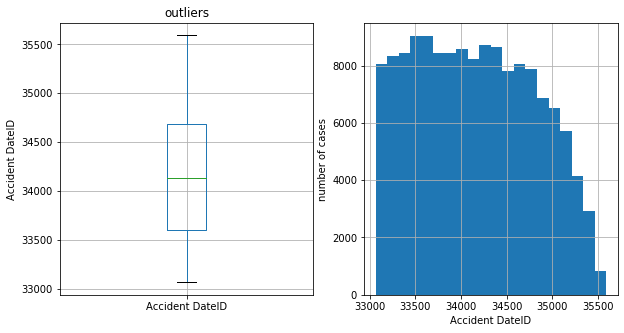

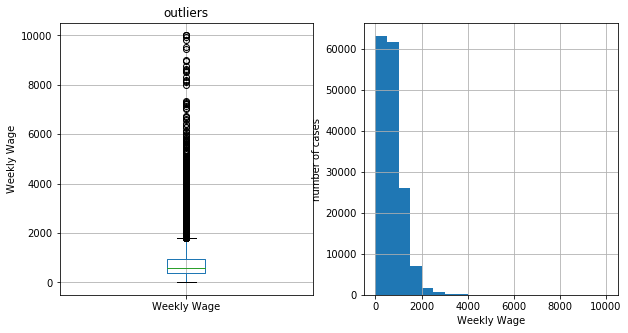

In [30]:
for var in continuous:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    fig = df.boxplot(column=var)
    fig.set_title('outliers')
    fig.set_ylabel(var)
    
    plt.subplot(1,2,2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('number of cases')
    fig.set_xlabel(var)
    
    plt.show()

In [31]:
df_copy = df.copy()
df_copy['Accident DateID_log'] = df_copy['Accident DateID'].map(lambda x: np.log(x))
df_copy['Accident DateID_rec'] = df_copy['Accident DateID'].map(lambda x: np.reciprocal(x))
df_copy['Accident DateID_sqrt'] = df_copy['Accident DateID'].map(lambda x: np.sqrt(x))

In [32]:
df_copy['Accident DateID'].skew(skipna = True)

0.13784093136273964

In [33]:
df_copy['Accident DateID_log'].skew(skipna = True)

0.111780695600532

In [34]:
df_copy['Accident DateID_rec'].skew(skipna = True)

0.0

In [35]:
df_copy['Accident DateID_sqrt'].skew(skipna = True)

0.12479843426881913

In [36]:
df['Accident DateID_rec'] = df['Accident DateID'].map(lambda x: np.reciprocal(x))
df.drop(['Accident DateID'], axis=1, inplace=True)

In [37]:
df_copy['Weekly Wage_log'] = df_copy['Weekly Wage'].map(lambda x: np.log(x) if x > 0 else 0)
df_copy['Weekly Wage_rec'] = df_copy['Weekly Wage'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
df_copy['Weekly Wage_sqrt'] = df_copy['Weekly Wage'].map(lambda x: np.sqrt(x))

In [38]:
df_copy['Weekly Wage'].skew(skipna = True)

2.567761783769324

In [39]:
df_copy['Weekly Wage_log'].skew(skipna = True)

-3.7163732293381053

In [40]:
df_copy['Weekly Wage_rec'].skew(skipna = True)

54.37108747760092

In [41]:
df_copy['Weekly Wage_sqrt'].skew(skipna = True)

0.40769228563241

In [42]:
df['Weekly Wage_sqrt'] = df['Weekly Wage'].map(lambda x: np.sqrt(x))
df.drop(['Weekly Wage'], axis=1, inplace=True)

In [43]:
def diagnostic_plot(df, variable):
    plt.figure(figsize=(16, 4))
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

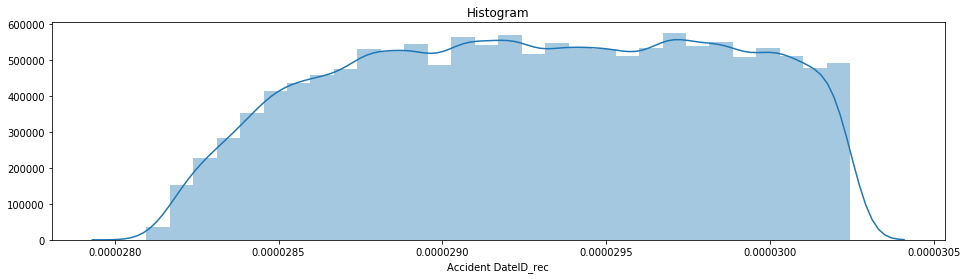

In [44]:
diagnostic_plot(df_copy, 'Accident DateID_rec')

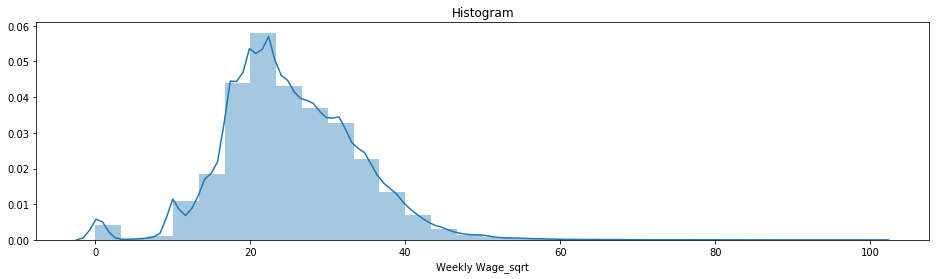

In [45]:
diagnostic_plot(df_copy, 'Weekly Wage_sqrt')

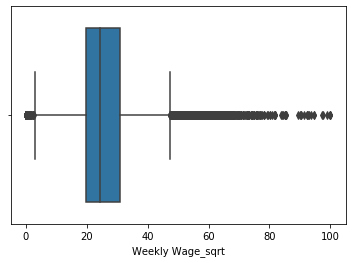

In [46]:
sns.boxplot(x=df['Weekly Wage_sqrt'])

In [47]:
def find_boundaries(df, variable):

    # calculate the boundaries anything outside the upper and lower boundaries is an outlier
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [48]:
upper_boundary, lower_boundary = find_boundaries(df, 'Weekly Wage_sqrt')
upper_boundary, lower_boundary

(51.146301218522304, -0.7634691525963717)

In [49]:
print('We have {} upper boundary outliers:'.format(len(df[df['Weekly Wage_sqrt'] > upper_boundary])))
print('We have {} lower boundary outliers:'.format(len(df[df['Weekly Wage_sqrt'] < lower_boundary])))

We have 860 upper boundary outliers:
We have 0 lower boundary outliers:


In [50]:
# identify the outliers in weekly wage_sqrt
outliers_weekly_wage = np.where(df['Weekly Wage_sqrt'] > upper_boundary, True, 
                                np.where(df['Weekly Wage_sqrt'] < lower_boundary, True, False))
outliers_weekly_wage

array([False, False, False, ..., False, False, False])

In [51]:
# trim the df of the outliers
df = df.loc[~(outliers_weekly_wage)]

In [52]:
# We have an imbalanced dataset where the majority of the observations did not take opiods.  
df['Opiods Used'].value_counts()/len(df)

False    0.896336
True     0.103664
Name: Opiods Used, dtype: float64

In [53]:
# transforming all features, besides weekly wage, to object type in order to make the pipeline work correctly
df[discrete] = df[discrete].astype('O')
df['Industry ID'] = df['Industry ID'].astype('O')
df['Surgery Flag'] = df['Surgery Flag'].astype('O')
df['Accident Source Code'] = df['Accident Source Code'].astype('O')
df['Orthopedic Surgery Payment Flag'] = df['Orthopedic Surgery Payment Flag'].astype('O')
df['Orthopedic Surgery Payment Flag'] *= 1
df['Opiods Used'] *= 1

In [54]:
df.head()

,Benefits State,Industry ID,Claimant Age,Claimant Sex,Claimant Marital Status,Number Dependents,Employment Status Flag,RTW Restriction Flag,Percent Impairment,NCCI Job Code,Surgery Flag,Disability Status,SIC Group,NCCI BINatureOfLossDescription,Accident Source Code,Orthopedic Surgery Payment Flag,HCPCS A Codes,HCPCS E Codes,HCPCS G Codes,HCPCS J Codes,HCPCS L Codes,HCPCS W Codes,ICD Group 6,ICD Group 13,ICD Group 18,ICD Group 19,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Muscle Relaxants,Opiods Used,Accident Type Group num,Accident DateID_rec,Weekly Wage_sqrt
0,OK,17,41,M,M,0,F,Y,0,5040,0,TTD,Gen. cont.,Strain,NaN,0,0,0,0,1,1,0,0,4,0,12,0,0,7,1,3,5,1,0,0,7,0.000030,22.668480
1,CO,17,49,M,M,0,F,N,10,5190,0,PPD,Gen. cont.,Inflammation,6314,1,3,0,0,3,0,0,2,12,0,12,4,1,4,12,1,4,9,0,1,6,NaN,34.438351
2,MD,17,47,M,U,0,F,N,0,5183,0,TTD,Gen. cont.,Foreign Body,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,2,0,0,NaN,0.000029,29.183728
3,IL,9,35,F,M,0,P,N,0,8868,0,TTD,Misc. Manuf. Ind.,Strain,7726,0,0,0,0,0,0,0,0,0,0,2,0,0,2,1,0,2,0,1,0,6,0.000030,17.320508
4,IL,9,30,F,M,0,F,,0,8868,0,TTD,Misc. Manuf. Ind.,Contusions,NaN,0,0,0,1,0,0,0,0,10,2,6,0,0,2,4,0,6,0,0,0,1,0.000030,24.494897


In [55]:
df.to_csv('df_clean.csv', encoding='utf-8', index=False)

## Train Test Split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Opiods Used', axis=1),
    df['Opiods Used'],
    test_size=0.3,
    stratify=df['Opiods Used'],
    shuffle=True,
    random_state=SEED)

In [57]:
y_train.shape, y_test.shape

((111829,), (47927,))

## Pipeline

In [58]:
# Imputes missing values for continuous features with more than 5% missing data with -99999.
feature_transform = make_pipeline(mdi.ArbitraryNumberImputer(arbitrary_number = -99999, variables='Accident DateID_rec'),
                                  #imputes categorical (object) features w/ more than 5% of nulls as 'missing'
                                  mdi.CategoricalVariableImputer(variables=['Disability Status',
                                                                            'NCCI BINatureOfLossDescription',
                                                                            'Accident Source Code',
                                                                            'Accident Type Group num'],
                                                                 imputation_method='missing'),
                                  # imputing categorical features w/less than 5% of missing values with the mode
                                  mdi.CategoricalVariableImputer(variables=['Claimant Sex', 
                                                                            'Claimant Marital Status', 
                                                                            'Employment Status Flag',
                                                                            'RTW Restriction Flag'],
                                                                 imputation_method='frequent'),
                                  #encoding rare categories for categorical and discrete features (Less than 1% is rare)
                                  ce.RareLabelCategoricalEncoder(tol=0.01, n_categories=6, 
                                            variables=['Benefits State', 'Industry ID', 'NCCI Job Code',
                                            'Employment Status Flag', 'SIC Group', 'NCCI BINatureOfLossDescription', 
                                            'Accident Type Group num', 'Claimant Age', 'Number Dependents', 
                                            'Percent Impairment', 'HCPCS A Codes', 'HCPCS E Codes', 
                                            'HCPCS G Codes', 'HCPCS J Codes', 'HCPCS L Codes', 
                                            'HCPCS W Codes', 'ICD Group 6', 'ICD Group 13', 
                                            'ICD Group 18', 'ICD Group 19', 'ICD Group 21', 
                                            'CPT Category - Anesthesia', 'CPT Category - Eval_Mgmt', 
                                            'CPT Category - Medicine', 'CPT Category - Path_Lab', 
                                            'CPT Category - Radiology', 'CPT Category - Surgery', 
                                            'NDC Class - Muscle Relaxants']),
                                  # We will use one_hot_encoding for categorical features
                                  ce.OneHotCategoricalEncoder(
                                      variables=['Benefits State', 'Industry ID', 'Claimant Sex',
                                                 'Claimant Marital Status','Employment Status Flag', 
                                                 'RTW Restriction Flag','Disability Status',
                                                 'SIC Group','NCCI Job Code','NCCI BINatureOfLossDescription',
                                                 'Accident Source Code','Accident Type Group num'],drop_last=True),
                                  # We are going to use ordinal encoding according to the target mean to the target feature
                                  ce.OrdinalCategoricalEncoder(encoding_method='ordered', 
                                    variables=['Claimant Age','Number Dependents','Percent Impairment',
                                               'HCPCS A Codes', 'HCPCS E Codes','HCPCS G Codes', 
                                               'HCPCS J Codes', 'HCPCS L Codes', 'HCPCS W Codes',
                                               'ICD Group 6', 'ICD Group 13', 'ICD Group 18', 
                                               'ICD Group 19','ICD Group 21', 'CPT Category - Anesthesia', 
                                               'CPT Category - Eval_Mgmt','CPT Category - Medicine', 
                                               'CPT Category - Path_Lab','CPT Category - Radiology', 
                                               'CPT Category - Surgery','NDC Class - Muscle Relaxants']))

In [59]:
feature_transform.fit(X_train, y_train)

Pipeline(steps=[('arbitrarynumberimputer',
                 ArbitraryNumberImputer(arbitrary_number=-99999,
                                        variables=['Accident DateID_rec'])),
                ('categoricalvariableimputer-1',
                 CategoricalVariableImputer(variables=['Disability Status',
                                                       'NCCI '
                                                       'BINatureOfLossDescription',
                                                       'Accident Source Code',
                                                       'Accident Type Group '
                                                       'num'])),
                ('categoricalvariableimputer-2',
                 CategoricalVariableImp...
                                                      'Number Dependents',
                                                      'Percent Impairment',
                                                      'HCPCS A Codes',
       

In [60]:
X_train_clean = feature_transform.transform(X_train)
X_test_clean = feature_transform.transform(X_test)

In [61]:
print(X_train_clean.info())
print(X_test_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111829 entries, 148302 to 77888
Columns: 156 entries, Claimant Age to Accident Type Group num_7
dtypes: float64(2), int64(152), object(2)
memory usage: 134.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47927 entries, 66337 to 77771
Columns: 156 entries, Claimant Age to Accident Type Group num_7
dtypes: float64(2), int64(152), object(2)
memory usage: 57.4+ MB
None


In [62]:
X_train_clean.shape

(111829, 156)

## Feature Scaling


### Standardization

In [63]:
scaler = StandardScaler()
scaler.fit(X_train_clean)

X_train_std = scaler.transform(X_train_clean)
X_test_std = scaler.transform(X_test_clean)


In [64]:
X_test_std.shape

(47927, 156)

In [65]:
X_train_clean.columns

Index(['Claimant Age', 'Number Dependents', 'Percent Impairment',
       'Surgery Flag', 'Orthopedic Surgery Payment Flag', 'HCPCS A Codes',
       'HCPCS E Codes', 'HCPCS G Codes', 'HCPCS J Codes', 'HCPCS L Codes',
       ...
       'Accident Source Code_6342.0', 'Accident Type Group num_5',
       'Accident Type Group num_2', 'Accident Type Group num_Missing',
       'Accident Type Group num_6', 'Accident Type Group num_1',
       'Accident Type Group num_8', 'Accident Type Group num_4',
       'Accident Type Group num_Rare', 'Accident Type Group num_7'],
      dtype='object', length=156)

In [66]:
col_names = X_train_clean.columns
col_names

Index(['Claimant Age', 'Number Dependents', 'Percent Impairment',
       'Surgery Flag', 'Orthopedic Surgery Payment Flag', 'HCPCS A Codes',
       'HCPCS E Codes', 'HCPCS G Codes', 'HCPCS J Codes', 'HCPCS L Codes',
       ...
       'Accident Source Code_6342.0', 'Accident Type Group num_5',
       'Accident Type Group num_2', 'Accident Type Group num_Missing',
       'Accident Type Group num_6', 'Accident Type Group num_1',
       'Accident Type Group num_8', 'Accident Type Group num_4',
       'Accident Type Group num_Rare', 'Accident Type Group num_7'],
      dtype='object', length=156)

In [67]:
X_train_std_df = pd.DataFrame(X_train_std, columns=col_names)
X_test_std_df = pd.DataFrame(X_test_std, columns=col_names)

In [68]:
X_test_std_df.shape

(47927, 156)

## Baseline Model

### All Features & Imbalanced Target

In [69]:
models = []
models.append(('log_reg', LogisticRegression(max_iter=10000, random_state=42)))
models.append(('rf_classifer', RandomForestClassifier(random_state=42)))
models.append(('bayes', GaussianNB()))
models.append(('gbc', GradientBoostingClassifier()))

base_model_train = []
base_model_test = []

for name, classifier in models:
    scores = cross_val_score(classifier, X_train_std_df, y_train, cv=5, scoring='recall')
    base_model_train.append(scores.mean().round(4))
    print(scores)
    print('{}: Avg CV recall using all features on training data: {}'.format(name, scores.mean().round(4)))
    
    classifier.fit(X_train_std_df, y_train)
    y_preds = classifier.predict(X_test_std_df)
    test_recall = recall_score(y_test, y_preds, average='binary')
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    base_model_test.append(test_recall.round(4))
    print('{}: Recall w/all features on test data {}:'.format(name, test_recall.round(4)))
    print(test_class)
    print(cnf_matrix)
    print('-----------------------------------------------------------')

[0.78999569 0.78654592 0.79732643 0.78429681 0.7903365 ]
log_reg: Avg CV recall using all features on training data: 0.7897
log_reg: Recall w/all features on test data 0.7985:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     42959
           1       0.87      0.80      0.83      4968

    accuracy                           0.97     47927
   macro avg       0.92      0.89      0.91     47927
weighted avg       0.97      0.97      0.97     47927

[[42345   614]
 [ 1001  3967]]
-----------------------------------------------------------
[0.71021992 0.71021992 0.70677016 0.70060397 0.68723037]
rf_classifer: Avg CV recall using all features on training data: 0.703
rf_classifer: Recall w/all features on test data 0.7114:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42959
           1       0.90      0.71      0.79      4968

    accuracy                           0.96     47927
   

In [70]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_std_sm, y_train_sm = sm.fit_resample(X_train_std_df, y_train)

/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Model #1: All Features & Balanced w/SMOTE

In [71]:
models = []
models.append(('log_reg', LogisticRegression(max_iter=10000, random_state=42)))
models.append(('rf_classifer', RandomForestClassifier(random_state=42)))
models.append(('bayes', GaussianNB()))
models.append(('gbc', GradientBoostingClassifier()))

model1_train = []
model1_test = []

for name, classifier in models:
    pipeline = make_pipeline(sm, classifier)
    scores = cross_val_score(pipeline, X_train_std_df, y_train, cv=5, scoring='recall')
    model1_train.append(scores.mean().round(4))
    print(scores)
    print('{}: Avg CV Recall w/All Features & SMOTE: {}'.format(name, scores.mean().round(4)))
    
    classifier.fit(X_train_std_sm, y_train_sm)
    y_preds = classifier.predict(X_test_std_df)
    test_recall = recall_score(y_test, y_preds)
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    model1_test.append(test_recall.round(4))
    print('{}: Recall w/All Features & SMOTE on test data {}:'.format(name, test_recall.round(4)))
    print(test_class)
    print(cnf_matrix)
    print('-----------------------------------------------------------')

/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in ver

[0.93876671 0.94394135 0.94825356 0.94348576 0.93399482]
log_reg: Avg CV Recall w/All Features & SMOTE: 0.9417
log_reg: Recall w/All Features & SMOTE on test data 0.9503:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     42959
           1       0.68      0.95      0.79      4968

    accuracy                           0.95     47927
   macro avg       0.84      0.95      0.88     47927
weighted avg       0.96      0.95      0.95     47927

[[40747  2212]
 [  247  4721]]
-----------------------------------------------------------


/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in ver

[0.77878396 0.76498491 0.77662786 0.76704055 0.76056946]
rf_classifer: Avg CV Recall w/All Features & SMOTE: 0.7696
rf_classifer: Recall w/All Features & SMOTE on test data 0.7792:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     42959
           1       0.85      0.78      0.81      4968

    accuracy                           0.96     47927
   macro avg       0.91      0.88      0.90     47927
weighted avg       0.96      0.96      0.96     47927

[[42256   703]
 [ 1097  3871]]
-----------------------------------------------------------


/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in ver

[0.89693834 0.90901251 0.89866322 0.90163934 0.90983607]
bayes: Avg CV Recall w/All Features & SMOTE: 0.9032
bayes: Recall w/All Features & SMOTE on test data 0.9155:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     42959
           1       0.29      0.92      0.44      4968

    accuracy                           0.76     47927
   macro avg       0.64      0.83      0.64     47927
weighted avg       0.91      0.76      0.80     47927

[[31832 11127]
 [  420  4548]]
-----------------------------------------------------------


/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in ver

[0.84777922 0.8348426  0.83829237 0.8377912  0.83045729]
gbc: Avg CV Recall w/All Features & SMOTE: 0.8378
gbc: Recall w/All Features & SMOTE on test data 0.8504:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     42959
           1       0.81      0.85      0.83      4968

    accuracy                           0.96     47927
   macro avg       0.90      0.91      0.91     47927
weighted avg       0.97      0.96      0.96     47927

[[41988   971]
 [  743  4225]]
-----------------------------------------------------------


## Feature Selection

### Feature Selection Using RF

In [72]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)

rf_selector.fit(X_train_std_sm, y_train_sm)
feature_imp = pd.Series(rf_selector.feature_importances_,
                        index=X_train_std_df.columns).sort_values(ascending=False)
feature_imp[:30]

NDC Class - Muscle Relaxants            0.128317
CPT Category - Eval_Mgmt                0.088760
CPT Category - Medicine                 0.080741
CPT Category - Radiology                0.079880
CPT Category - Path_Lab                 0.068115
ICD Group 13                            0.066279
HCPCS E Codes                           0.059203
HCPCS J Codes                           0.059017
CPT Category - Anesthesia               0.030101
ICD Group 21                            0.028316
CPT Category - Surgery                  0.026873
HCPCS A Codes                           0.024682
HCPCS G Codes                           0.020865
HCPCS L Codes                           0.019254
Percent Impairment                      0.019243
ICD Group 6                             0.018461
Orthopedic Surgery Payment Flag         0.018080
RTW Restriction Flag_N                  0.012597
ICD Group 19                            0.011238
Surgery Flag                            0.008087
Weekly Wage_sqrt    

In [73]:
sum(feature_imp[0:30])

0.9198169825805103

In [74]:
X_train_rf = X_train_std_df[feature_imp[:30].index]
X_test_rf = X_test_std_df[feature_imp[:30].index]


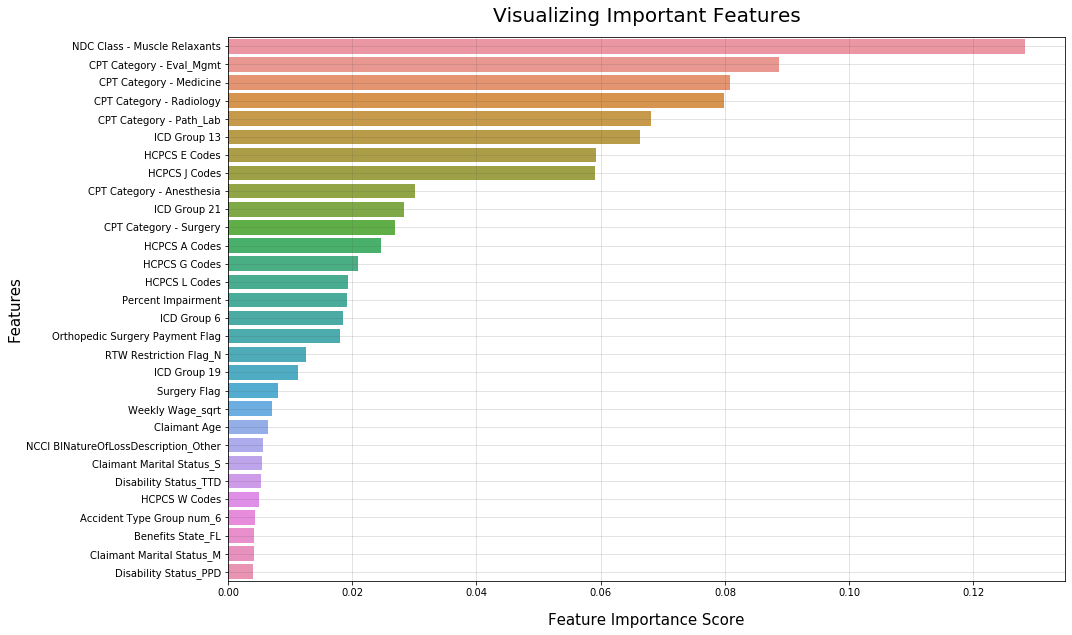

In [90]:
plt.figure(figsize=(15,10))
sns.barplot(x=feature_imp[0:30], y=feature_imp.index[0:30])
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=15, labelpad=15)
plt.ylabel('Features', fontsize=15)
plt.title("Visualizing Important Features", fontsize=20, pad=15)
plt.grid(b=False, which='major', color='#555555', linestyle='-', alpha=0.2)
plt.show()

### Model #2: RF Features & Imbalanced Target

In [76]:
models = []
models.append(('log_reg', LogisticRegression(max_iter=10000, random_state=42)))
models.append(('rf_classifer', RandomForestClassifier(random_state=42)))
models.append(('bayes', GaussianNB()))
models.append(('gbc', GradientBoostingClassifier()))

model2_train = []
model2_test = []

for name, classifier in models:
    scores = cross_val_score(classifier, X_train_rf, y_train, cv=5, scoring='recall')
    model2_train.append(scores.mean().round(3))
    print(scores)
    print('{}: Avg CV Recall on RF Features: {}'.format(name, scores.mean().round(3)))
    
    classifier.fit(X_train_rf, y_train)
    y_preds = classifier.predict(X_test_rf)
    test_recall = recall_score(y_test, y_preds, average='binary')
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    model2_test.append(test_recall.round(3))
    print('{}: Recall w/RF features on test data {}:'.format(name, test_recall.round(3)))
    print(test_class)
    print(cnf_matrix)
    print('-----------------------------------------------------------')

[0.75247952 0.75032342 0.74299267 0.76100086 0.75107852]
log_reg: Avg CV Recall on RF Features: 0.752
log_reg: Recall w/RF features on test data 0.76:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     42959
           1       0.85      0.76      0.80      4968

    accuracy                           0.96     47927
   macro avg       0.91      0.87      0.89     47927
weighted avg       0.96      0.96      0.96     47927

[[42284   675]
 [ 1192  3776]]
-----------------------------------------------------------
[0.75118586 0.73695558 0.74816731 0.74417601 0.73684211]
rf_classifer: Avg CV Recall on RF Features: 0.743
rf_classifer: Recall w/RF features on test data 0.75:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42959
           1       0.87      0.75      0.81      4968

    accuracy                           0.96     47927
   macro avg       0.92      0.87      0.89     4792

### Model #3: RF Features & Balanced w/SMOTE

In [77]:
X_train_rf_sm, y_train_sm = sm.fit_resample(X_train_rf, y_train)

models = []
models.append(('log_reg', LogisticRegression(max_iter=10000, random_state=42)))
models.append(('rf_classifer', RandomForestClassifier(random_state=42)))
models.append(('bayes', GaussianNB()))
models.append(('gbc', GradientBoostingClassifier()))

sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
skf = StratifiedKFold(n_splits=5)

model3_train = []
model3_test = []

for name, classifier in models:
    pipeline = make_pipeline(sm, classifier)
    scores = cross_val_score(pipeline, X_train_rf, y_train, cv=skf, scoring='recall')
    model3_train.append(scores.mean().round(3))
    print(scores)
    print('{}: Avg CV Recall w/RF Reatures: {}'.format(name, scores.mean().round(3)))
    
    classifier.fit(X_train_rf_sm, y_train_sm)
    y_preds = classifier.predict(X_test_rf)
    test_recall = recall_score(y_test, y_preds, average='binary')
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    model3_test.append(test_recall.round(3))
    print('{}: Recall w/RF on test data {}:'.format(name, test_recall.round(3)))
    print(test_class)
    print(cnf_matrix)
    print('-----------------------------------------------------------')

/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in ver

[0.94006037 0.93747305 0.94351013 0.93615186 0.94046592]
log_reg: Avg CV Recall w/RF Reatures: 0.94
log_reg: Recall w/RF on test data 0.945:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     42959
           1       0.62      0.95      0.75      4968

    accuracy                           0.94     47927
   macro avg       0.81      0.94      0.86     47927
weighted avg       0.95      0.94      0.94     47927

[[40130  2829]
 [  273  4695]]
-----------------------------------------------------------


/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in ver

[0.81285037 0.80681328 0.81500647 0.81320104 0.8041415 ]
rf_classifer: Avg CV Recall w/RF Reatures: 0.81
rf_classifer: Recall w/RF on test data 0.813:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     42959
           1       0.81      0.81      0.81      4968

    accuracy                           0.96     47927
   macro avg       0.90      0.90      0.90     47927
weighted avg       0.96      0.96      0.96     47927

[[42035   924]
 [  929  4039]]
-----------------------------------------------------------


/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in ver

[0.93747305 0.94782234 0.94307891 0.93830889 0.94348576]
bayes: Avg CV Recall w/RF Reatures: 0.942
bayes: Recall w/RF on test data 0.949:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     42959
           1       0.46      0.95      0.62      4968

    accuracy                           0.88     47927
   macro avg       0.73      0.91      0.77     47927
weighted avg       0.94      0.88      0.90     47927

[[37436  5523]
 [  251  4717]]
-----------------------------------------------------------


/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in ver

[0.86071583 0.86287193 0.86416559 0.86626402 0.86238136]
gbc: Avg CV Recall w/RF Reatures: 0.863
gbc: Recall w/RF on test data 0.872:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     42959
           1       0.76      0.87      0.81      4968

    accuracy                           0.96     47927
   macro avg       0.87      0.92      0.90     47927
weighted avg       0.96      0.96      0.96     47927

[[41626  1333]
 [  637  4331]]
-----------------------------------------------------------


In [78]:
classifiers = ['Log_Regression', 'Random_Forest', 'Naive_Bayes', 'Gradient_Boosting_clf']
idx = ['All_Feat_Imbalance_Train', 'All_Feat_Imbalance_Test','All_Feat_Smote_Train',
       'All_Feat_Smote_Test','RF_Imbalance_Train', 'RF_Imbalance_Test',
       'RF_Smote_Train','RF_Smote_Test']
combined_results = pd.DataFrame([base_model_train,base_model_test,
                                 model1_train, model1_test, model2_train,
                                 model2_test, model3_train, model3_test],
                                 columns=classifiers, index=idx)

test_results = pd.DataFrame([base_model_test, model1_test, model2_test,
                             model3_test], columns=classifiers, index=idx[1:8:2])



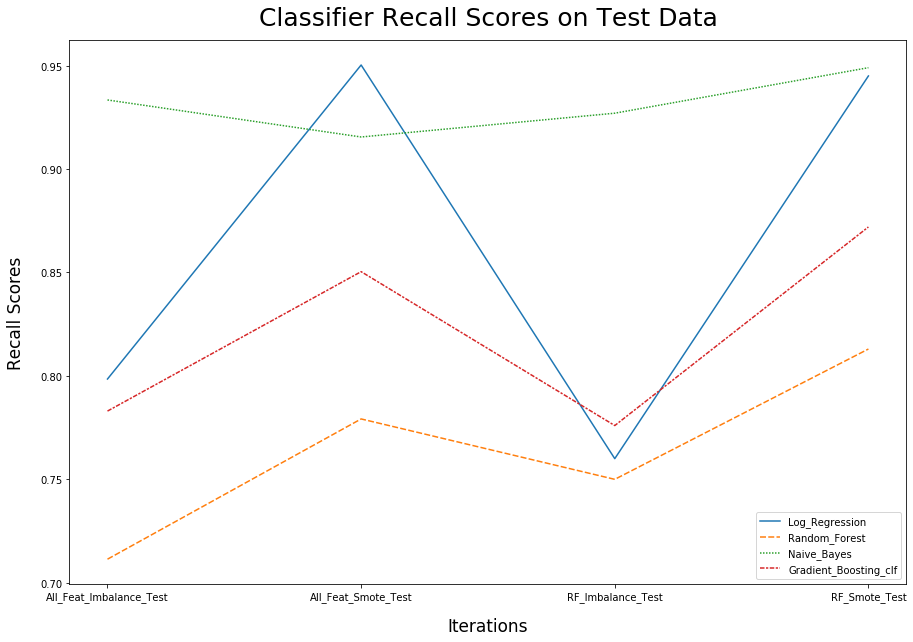

In [118]:
plt.figure(figsize=(15,10))
sns.lineplot(data=test_results[['Log_Regression', 'Random_Forest',
                             'Naive_Bayes', 'Gradient_Boosting_clf']])
plt.xlabel('Iterations', fontsize=17, labelpad=15)             
plt.ylabel('Recall Scores', fontsize=17, labelpad=15)
plt.title('Classifier Recall Scores on Test Data',fontsize=25, pad=15)
plt.show()

In [80]:
combined_results

,Log_Regression,Random_Forest,Naive_Bayes,Gradient_Boosting_clf
All_Feat_Imbalance_Train,0.7897,0.7030,0.9258,0.7731
All_Feat_Imbalance_Test,0.7985,0.7114,0.9334,0.7830
All_Feat_Smote_Train,0.9417,0.7696,0.9032,0.8378
All_Feat_Smote_Test,0.9503,0.7792,0.9155,0.8504
RF_Imbalance_Train,0.7520,0.7430,0.9170,0.7680
RF_Imbalance_Test,0.7600,0.7500,0.9270,0.7760
RF_Smote_Train,0.9400,0.8100,0.9420,0.8630
RF_Smote_Test,0.9450,0.8130,0.9490,0.8720


In [81]:
test_results

,Log_Regression,Random_Forest,Naive_Bayes,Gradient_Boosting_clf
All_Feat_Imbalance_Test,0.7985,0.7114,0.9334,0.7830
All_Feat_Smote_Test,0.9503,0.7792,0.9155,0.8504
RF_Imbalance_Test,0.7600,0.7500,0.9270,0.7760
RF_Smote_Test,0.9450,0.8130,0.9490,0.8720


## Hyperparameter Tuning

In [126]:
clf_lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [155]:
clf_lr = LogisticRegression(max_iter=10000, random_state=SEED)

penalty = ['l1','l2']
C = [0.001, 0.0015,]

skf = StratifiedKFold(n_splits=5)
pipeline = make_pipeline(sm, clf_lr)
param_grid = dict(logisticregression__penalty=penalty,
                  logisticregression__C=C)

grid = GridSearchCV(pipeline, 
                    param_grid=param_grid,
                    scoring='recall', 
                    verbose=1, cv=skf)

grid_results = grid.fit(X_train_rf, y_train) 
print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 239, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 44

/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 239, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/kamilmysiak/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver

Best Score:  0.9436726877529328
Best Params:  {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}


## Training Classifier with Optimized Hyperparameters

In [160]:
X_train_rf_sm, y_train_sm = sm.fit_resample(X_train_rf, y_train)
clf_lr = LogisticRegression(max_iter=10000, penalty='l2', C=0.0001, random_state=42)

clf_lr.fit(X_train_rf_sm, y_train_sm)
y_preds = clf_lr.predict(X_test_rf)
test_recall = recall_score(y_test, y_preds).round(3)
test_class = classification_report(y_test, y_preds)
cm = confusion_matrix(y_test, y_preds)
print('Log Regression Recall w/RF on test data {}:'.format(test_recall.round(3)))
print(test_class)
print(cm)


Log Regression Recall w/RF on test data 0.954:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     42959
           1       0.60      0.95      0.74      4968

    accuracy                           0.93     47927
   macro avg       0.80      0.94      0.85     47927
weighted avg       0.95      0.93      0.94     47927

[[39861  3098]
 [  231  4737]]


# TESTING PLEASE IGNORE

In [ ]:
classifiers = [
    {'name': 'Log Regression', 'classifier': LogisticRegression(max_iter=10000, random_state=SEED)},
    {'name': 'Random Forest', 'classifier': RandomForestClassifier()},
    {'name': 'Naive Bayes', 'classifier': GaussianNB()},
    {'name': 'Gradient Boosting Classifier', 'classifier': GradientBoostingClassifier(random_state=SEED)}
]

sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_rfe_smote, y_train_smote = sm.fit_sample(X_train_rfe, y_train)

results = pd.DataFrame(columns =['classifier', 'FPR', 'TPR', 'AUC'])
plt.figure(figsize=(13,8))
for clf in classifiers:
    model = clf['classifier']
    model.fit(X_train_rfe_smote, y_train_smote)
    y_preds = model.predict(X_test_rfe)
    y_proba = model.predict_proba(X_test_rfe)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, model.predict(X_test_rfe))
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (clf['name'], auc))
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC Curves', fontsize=20)
plt.legend(loc="lower right")
plt.show()  